In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import os 

In [8]:
#os.chdir('../') # Run once
DATA_PATH = f"{os.getcwd()}/data/dataset.csv"

In [127]:
data = pd.read_csv(DATA_PATH)
data.head()

,user_id,number_of_ticks,date_created,chapter,book,numberofentriesofbook,numberofusersofbook,product_manning_id,user_owns_book
0,-2147277864,1,"""2019-10-27 08:58:15""",chapter-8,bhargava,888,440,610,1
1,-2146355313,8,"""2019-12-14 10:05:50""",chapter-8,fain3,737,225,1069,1
2,-2146355313,8,"""2019-12-14 10:05:50""",chapter-1,ramamurthy,715,202,1120,1
3,-2146355313,8,"""2019-12-14 10:05:50""",chapter-1,thomas,445,136,816,1
4,-2146168866,2,"""2019-11-27 05:09:29""",about-this-book,prasanna,21,14,273,0


In [55]:
data.shape

(4999, 9)

This dataset contains 4999 observations, each defined by nine features.

**Assess extent of data preparation**
- How many users are big readers?
- Which book is owned by the most?
- Which book is read for the longest in each session?
- How many readers own the books they read?

In [56]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4999 entries, 0 to 4998
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   user_id                4999 non-null   int64 
 1   number_of_ticks        4999 non-null   int64 
 2   date_created           4999 non-null   object
 3   chapter                4999 non-null   object
 4   book                   4999 non-null   object
 5   numberofentriesofbook  4999 non-null   int64 
 6   numberofusersofbook    4999 non-null   int64 
 7   product_manning_id     4999 non-null   int64 
 8   user_owns_book         4999 non-null   int64 
dtypes: int64(6), object(3)
memory usage: 351.6+ KB


In [20]:
data["user_id"].value_counts()

2021139802    653
2088445927    331
2074479722    106
2135041721    104
2074434789     89
             ... 
2054614214      1
2053648004      1
2114289612      1
2053262764      1
2147277864      1
Name: user_id, Length: 641, dtype: int64

In [21]:
data["number_of_ticks"].value_counts()

1      1923
2       674
3       368
4       240
5       171
       ... 
359       1
94        1
157       1
120       1
98        1
Name: number_of_ticks, Length: 158, dtype: int64

In [23]:
data["user_owns_book"].value_counts()

1    2875
0    2124
Name: user_owns_book, dtype: int64

In [24]:
data["book"].value_counts()

windmill      162
elgendy       134
skeet5        103
mcnamara       99
chollet        91
             ... 
black2          1
rosenberg       1
rosenbaum2      1
jones           1
wagner          1
Name: book, Length: 334, dtype: int64

**Feature transformation**

In [107]:
data["date_created"] = data["date_created"].str.replace('"', '')
data["date_created"] = data["date_created"].str.strip()
data["date_created"] = pd.to_datetime(data["date_created"], format="%Y-%m-%d %H:%M:%S")

In [108]:
data["user_id"] = data["user_id"].abs()

Note that user_id remains an int64 data type because we will be sorting it later (mathematical operation)


---

### Create edge list

In [109]:
data = data.sort_values(by=["user_id", "date_created"])

In [110]:
data["source"] = data["book"]
data["target"] = data["book"].shift(-1)
data["target_user"] = data["user_id"].shift(-1)
data["user_check"] = np.where((data["target_user"] == data["user_id"]), data["user_id"], np.nan)

In [112]:
data = data.dropna(subset=["user_check"])

In [113]:
data

,user_id,number_of_ticks,date_created,chapter,book,numberofentriesofbook,numberofusersofbook,product_manning_id,user_owns_book,source,target,target_user,user_check
4997,2019295583,5,2019-11-12 13:47:10,chapter-7,urma2,2210,500,786,1,urma2,sholmes2,2.019296e+09,2.019296e+09
4979,2019295583,2,2019-11-26 07:39:39,chapter-3,sholmes2,705,148,901,0,sholmes2,sholmes2,2.019296e+09,2.019296e+09
4980,2019295583,2,2019-11-26 07:40:39,chapter-3,sholmes2,705,148,901,0,sholmes2,urma2,2.019296e+09,2.019296e+09
4995,2019295583,3,2019-11-26 07:44:44,chapter-1,urma2,2210,500,786,1,urma2,urma2,2.019296e+09,2.019296e+09
4996,2019295583,2,2019-11-26 07:46:14,chapter-1,urma2,2210,500,786,1,urma2,rodger,2.019296e+09,2.019296e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...
42,2145886989,4,2019-12-15 22:51:01,chapter-6,mcnamara,2533,461,880,1,mcnamara,mcnamara,2.145887e+09,2.145887e+09
43,2145886989,8,2019-12-15 22:53:01,chapter-6,mcnamara,2533,461,880,1,mcnamara,mcnamara,2.145887e+09,2.145887e+09
44,2145886989,48,2019-12-15 22:57:01,chapter-6,mcnamara,2533,461,880,1,mcnamara,mcnamara,2.145887e+09,2.145887e+09
1,2146355313,8,2019-12-14 10:05:50,chapter-8,fain3,737,225,1069,1,fain3,ramamurthy,2.146355e+09,2.146355e+09


In [118]:
G = nx.from_pandas_edgelist(data, "source", "target")

In [124]:
nx.draw(G, with_labels=False);

TypeError: '_AxesStack' object is not callable

<Figure size 640x480 with 0 Axes>

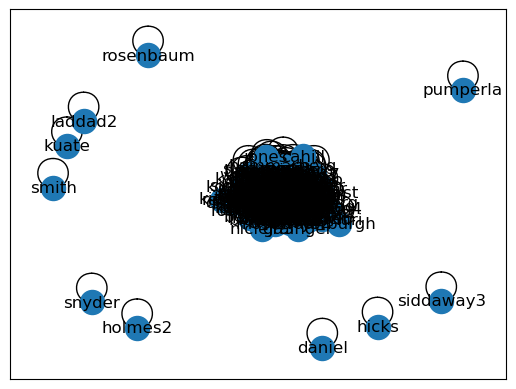

In [123]:
nx.draw_networkx(G);

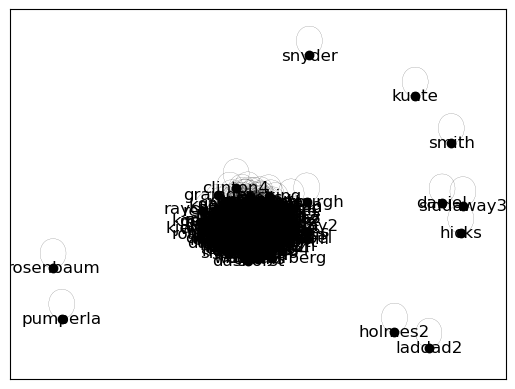

In [126]:
options = {"node_color": "black", "node_size": 50, "linewidths": 0, "width": 0.1}
nx.draw_networkx(G, **options)
plt.show()

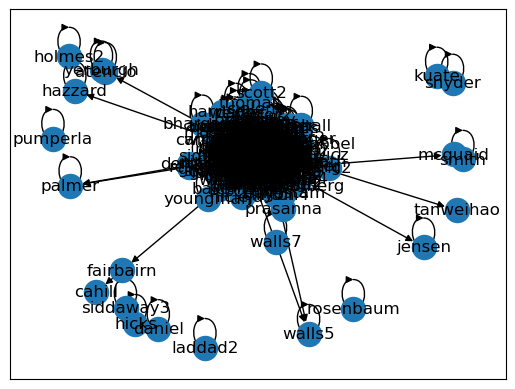

In [128]:
data=data.sort_values(by=['user_id','date_created'])
data["source"] =data["book"]
data["target"]= data["source"].shift(-1)  
data["user_check"]= data["user_id"].shift(-1)
data['keep_drop'] = np.where((data['user_check'] == data['user_id'])
                     , data['user_id'], np.nan)
data=data.dropna(subset=["keep_drop"])
G=nx.from_pandas_edgelist(data,"source",'target', create_using=nx.DiGraph)

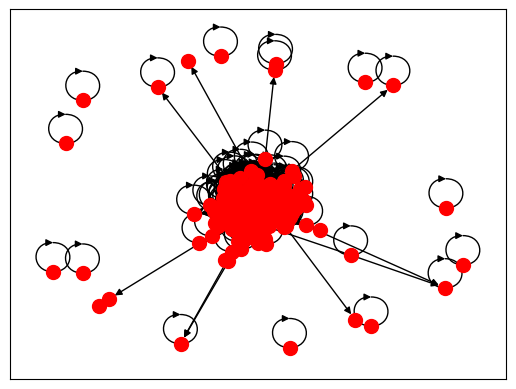

In [133]:
nx.draw_networkx(G, with_labels=False, node_size=100, node_color="red")